In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import requests

%matplotlib inline

In [27]:
csvpath = Path("../Data/EMR.csv")
stock_title = "Emerson Electric Co. Stock Price Prediction Model"

In [3]:
stock_df = pd.read_csv(csvpath, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [4]:
stock_df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-06-25,$96,2076210,$95.76,$96.49,$95.47
2021-06-24,$95.35,2585059,$94.97,$95.42,$94.14
2021-06-23,$94.50,2234949,$95.11,$96.03,$94.45
2021-06-22,$94.78,2058333,$94.75,$95.52,$93.96
2021-06-21,$94.93,2580230,$93.22,$95.08,$93.01


In [5]:
stock_df.sort_index(ascending=True, inplace=True)

In [6]:
stock_df = stock_df.rename(columns={"Close/Last": "Close"})

In [7]:
stock_df = stock_df[['Close']]
stock_df

,Close
Date,
2011-06-27,$53.87
2011-06-28,$54.78
2011-06-29,$54.93
2011-06-30,$56.25
2011-07-01,$57.09
...,...
2021-06-21,$94.93
2021-06-22,$94.78
2021-06-23,$94.50


In [8]:
stock_df['Close'] = stock_df['Close'].str.replace('$', '').astype(float)

In [9]:
stock_df

,Close
Date,
2011-06-27,53.87
2011-06-28,54.78
2011-06-29,54.93
2011-06-30,56.25
2011-07-01,57.09
...,...
2021-06-21,94.93
2021-06-22,94.78
2021-06-23,94.50


In [10]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window- 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [11]:
window_size = 100
feature_column = 0 # why 0?
target_column = 0 # Why 0?

X, y = window_data(stock_df, window_size, feature_column, target_column)

print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[53.87 54.78 54.93 56.25 57.09 57.16 57.64 58.15 57.19 56.36 56.18 56.06
  55.6  55.37 54.86 55.47 55.74 55.97 55.1  55.28 54.05 50.43 49.62 49.09
  49.06 47.06 48.46 46.01 45.39 42.53 44.73 41.89 45.68 46.3  46.91 46.07
  45.89 42.95 42.46 42.6  44.39 45.79 44.46 45.41 46.88 46.46 46.55 45.6
  44.03 43.45 44.74 44.38 43.4  43.8  44.65 45.   45.91 45.74 45.44 45.55
  43.75 41.98 42.33 43.7  44.07 43.23 43.79 41.31 40.69 42.13 43.27 44.5
  44.01 45.39 45.66 46.53 46.38 47.51 45.92 47.79 46.64 46.48 47.42 47.66
  46.52 47.15 50.14 49.61 48.12 48.31 49.79 51.82 51.26 50.89 52.13 50.11
  50.56 51.36 50.96 51.39]
 [54.78 54.93 56.25 57.09 57.16 57.64 58.15 57.19 56.36 56.18 56.06 55.6
  55.37 54.86 55.47 55.74 55.97 55.1  55.28 54.05 50.43 49.62 49.09 49.06
  47.06 48.46 46.01 45.39 42.53 44.73 41.89 45.68 46.3  46.91 46.07 45.89
  42.95 42.46 42.6  44.39 45.79 44.46 45.41 46.88 46.46 46.55 45.6  44.03
  43.45 44.74 44.38 43.4  43.8  44.65 45.   45.91 45.74 45.44 45.55 43.

In [12]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [13]:
y_train

array([[50.43],
       [49.56],
       [49.71],
       ...,
       [58.29],
       [58.  ],
       [58.  ]])

In [14]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Scale the y_test data
X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [15]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [16]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [17]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = window_size
# 20% of neurons to be dropped out
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [18]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [19]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
15/15 [==============================] - 12s 371ms/step - loss: 0.0242
Epoch 2/20
15/15 [==============================] - 6s 371ms/step - loss: 0.0129
Epoch 3/20
15/15 [==============================] - 6s 381ms/step - loss: 0.0105
Epoch 4/20
15/15 [==============================] - 6s 382ms/step - loss: 0.0091
Epoch 5/20
15/15 [==============================] - 6s 381ms/step - loss: 0.0089
Epoch 6/20
15/15 [==============================] - 6s 383ms/step - loss: 0.0089
Epoch 7/20
15/15 [==============================] - 6s 383ms/step - loss: 0.0092
Epoch 8/20
15/15 [==============================] - 6s 384ms/step - loss: 0.0082
Epoch 9/20
15/15 [==============================] - 6s 384ms/step - loss: 0.0083
Epoch 10/20
15/15 [==============================] - 6s 399ms/step - loss: 0.0076
Epoch 11/20
15/15 [==============================] - 6s 394ms/step - loss: 0.0072
Epoch 12/20
15/15 [==============================] - 6s 392ms/step - loss: 0.0065
Epoch 13/20
15/15 [=====

In [20]:
model.evaluate(X_test, y_test, verbose=0)

0.043353721499443054

In [21]:
predicted = model.predict(X_test)

In [22]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [23]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [24]:
stock_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = stock_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stock_actual_predicted.head()

,Actual,Predicted
Date,,
2017-08-23,58.82,58.017979
2017-08-24,58.43,57.834381
2017-08-25,58.02,57.669247
2017-08-28,58.56,57.516750
2017-08-29,58.40,57.390942


In [25]:
stock_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-06-21,92.27,83.087563
2021-06-22,94.93,82.918190
2021-06-23,94.78,82.696815
2021-06-24,94.50,82.461296
2021-06-25,95.35,82.230827


<AxesSubplot:title={'center':'Emerson Electric Co. Stock Price Prediction Model'}, xlabel='Date', ylabel='Price'>

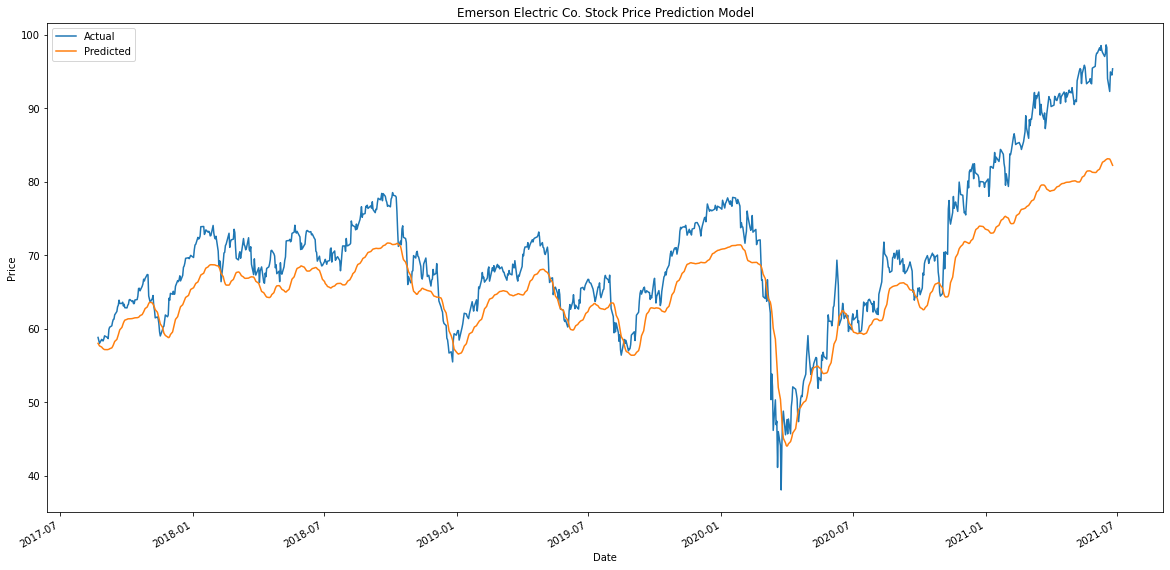

In [28]:
stock_actual_predicted.plot(figsize=(20,10), ylabel="Price", title=stock_title)